# DQN Model on Lunar-Lanader

## 1. Importing the Libraries

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models 

import gymnasium # To load the Environment

from collections import deque # for memory
import IPython

2024-08-07 16:57:00.442293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 16:57:00.458248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 16:57:00.462498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 16:57:00.471978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 16:57:01.165378: W tensorflow/compiler/tf2

## 2. Information about Environment

In [2]:
env = gymnasium.make('LunarLander-v2')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


## 3. HyperParameter 

In [3]:
learning_rate = 5e-4 
minibatch_size = 100
discount_factor = 0.99 # Initial rewards have more importance than later rewards
replay_buffer_size = int(1e5) # Length of the episodes stored in the memory
interpolation_parameter = 1e-3

## 4. Q-Network
- All layers are fully connected
- Input size is 8 
- Two hidden layers with 64 nodes and relu activation
- output size is 4

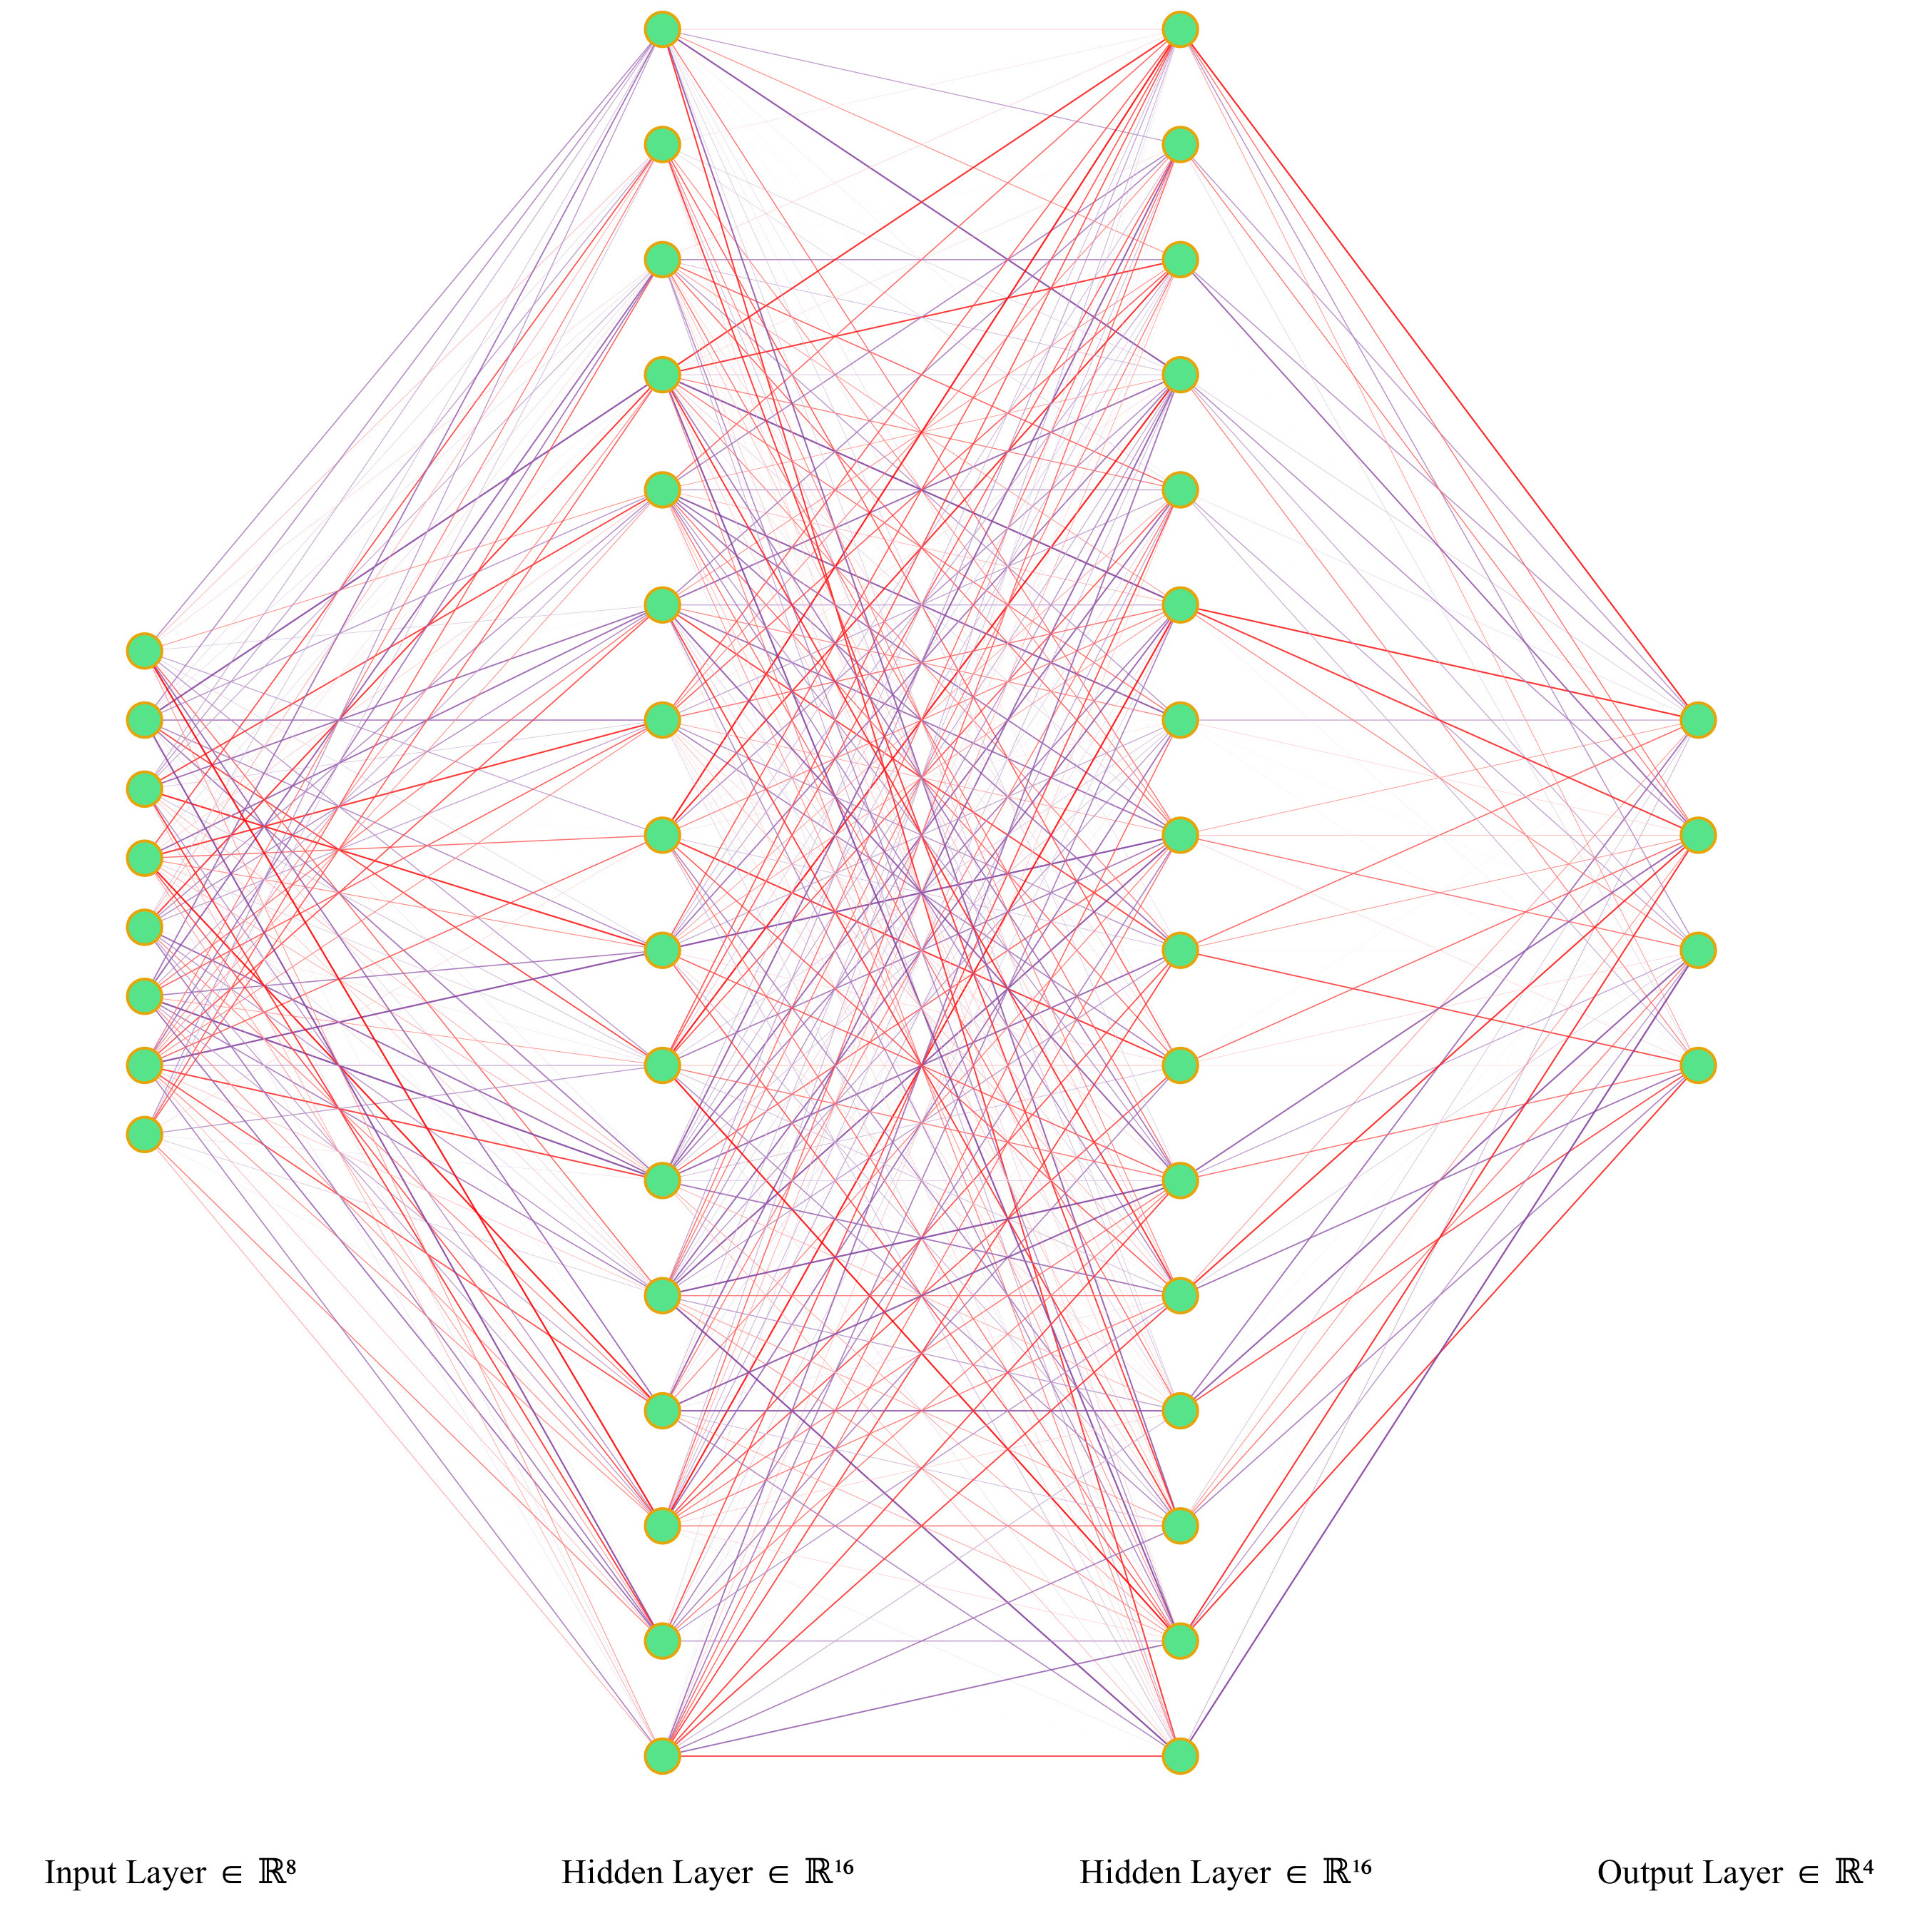

In [4]:
from IPython.display import Image
Image(filename='nn.jpg', width=300, height=300) 

In [5]:
class Network(tf.keras.Model):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        tf.random.set_seed(seed)
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(action_size)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        return self.fc3(x)

## 5. Replay memory

In [6]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states = np.vstack([e[0] for e in experiences if e is not None])
        actions = np.vstack([e[1] for e in experiences if e is not None])
        rewards = np.vstack([e[2] for e in experiences if e is not None])
        next_states = np.vstack([e[3] for e in experiences if e is not None])
        dones = np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)
        return states, next_states, actions, rewards, dones

## 6. Agent Class Which uses DQN

In [7]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = Network(state_size, action_size)
        self.target_qnetwork = Network(state_size, action_size)
        self.optimizer = optimizers.Adam(learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > minibatch_size:
                experiences = self.memory.sample(minibatch_size)
                self.learn(experiences, discount_factor)

    def act(self, state, epsilon=0.):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action_values = self.local_qnetwork(state)
        if random.random() > epsilon:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = tf.reduce_max(self.target_qnetwork(next_states), axis=1, keepdims=True)
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        with tf.GradientTape() as tape:
            q_expected = tf.reduce_sum(self.local_qnetwork(states) * tf.one_hot(actions, self.action_size), axis=1, keepdims=True)
            loss = tf.keras.losses.MSE(q_targets, q_expected)
        grads = tape.gradient(loss, self.local_qnetwork.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.local_qnetwork.trainable_variables))
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.trainable_variables, local_model.trainable_variables):
            target_param.assign(interpolation_parameter * local_param + (1.0 - interpolation_parameter) * target_param)

In [8]:
agent = Agent(state_size, number_actions)

I0000 00:00:1723030021.893172   12760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 16:57:01.931924: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 7. Training DQN 
- An episode is considered a solution if it scores at least 200 points in lunar lander
- We train max for 2000 episodes

In [10]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen=100)

for episode in range(1, number_episodes + 1):
    state, _ = env.reset()
    score = 0
    for t in range(maximum_number_timesteps_per_episode):
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    score = ((-6) * score) - 2000
    scores_on_100_episodes.append(score)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
    if np.mean(scores_on_100_episodes) >= 200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
        break

Episode 100	Average Score: -525.32
Episode 200	Average Score: -293.03
Episode 300	Average Score: 152.785
Episode 303	Average Score: 210.22
Environment solved in 303 episodes!	Average Score: 210.22
